In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import itertools
import cv2


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping

sns.set_style('darkgrid')


In [3]:
import warnings
warnings.filterwarnings("ignore")


In [4]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels


In [5]:
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)


In [6]:
def create_df(tr_dir, val_dir, ts_dir):
    # Train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # Validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    # Test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df


In [7]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size
    
    tr_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
    ts_gen = ImageDataGenerator(rescale=1./255)
    
    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    
    return train_gen, valid_gen, test_gen



In [8]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize=(20, 20))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()



In [9]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


In [11]:
# Get Dataframes
train_dir = r'C:\Users\renui\Downloads\Minor Project-II\archive\Brain_Stroke_CT-SCAN_image\Train'
valid_dir = r'C:\Users\renui\Downloads\Minor Project-II\archive\Brain_Stroke_CT-SCAN_image\Test'
test_dir = r'C:\Users\renui\Downloads\Minor Project-II\archive\Brain_Stroke_CT-SCAN_image\Validation'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)


Found 1843 validated image filenames belonging to 2 classes.
Found 437 validated image filenames belonging to 2 classes.
Found 235 validated image filenames belonging to 2 classes.


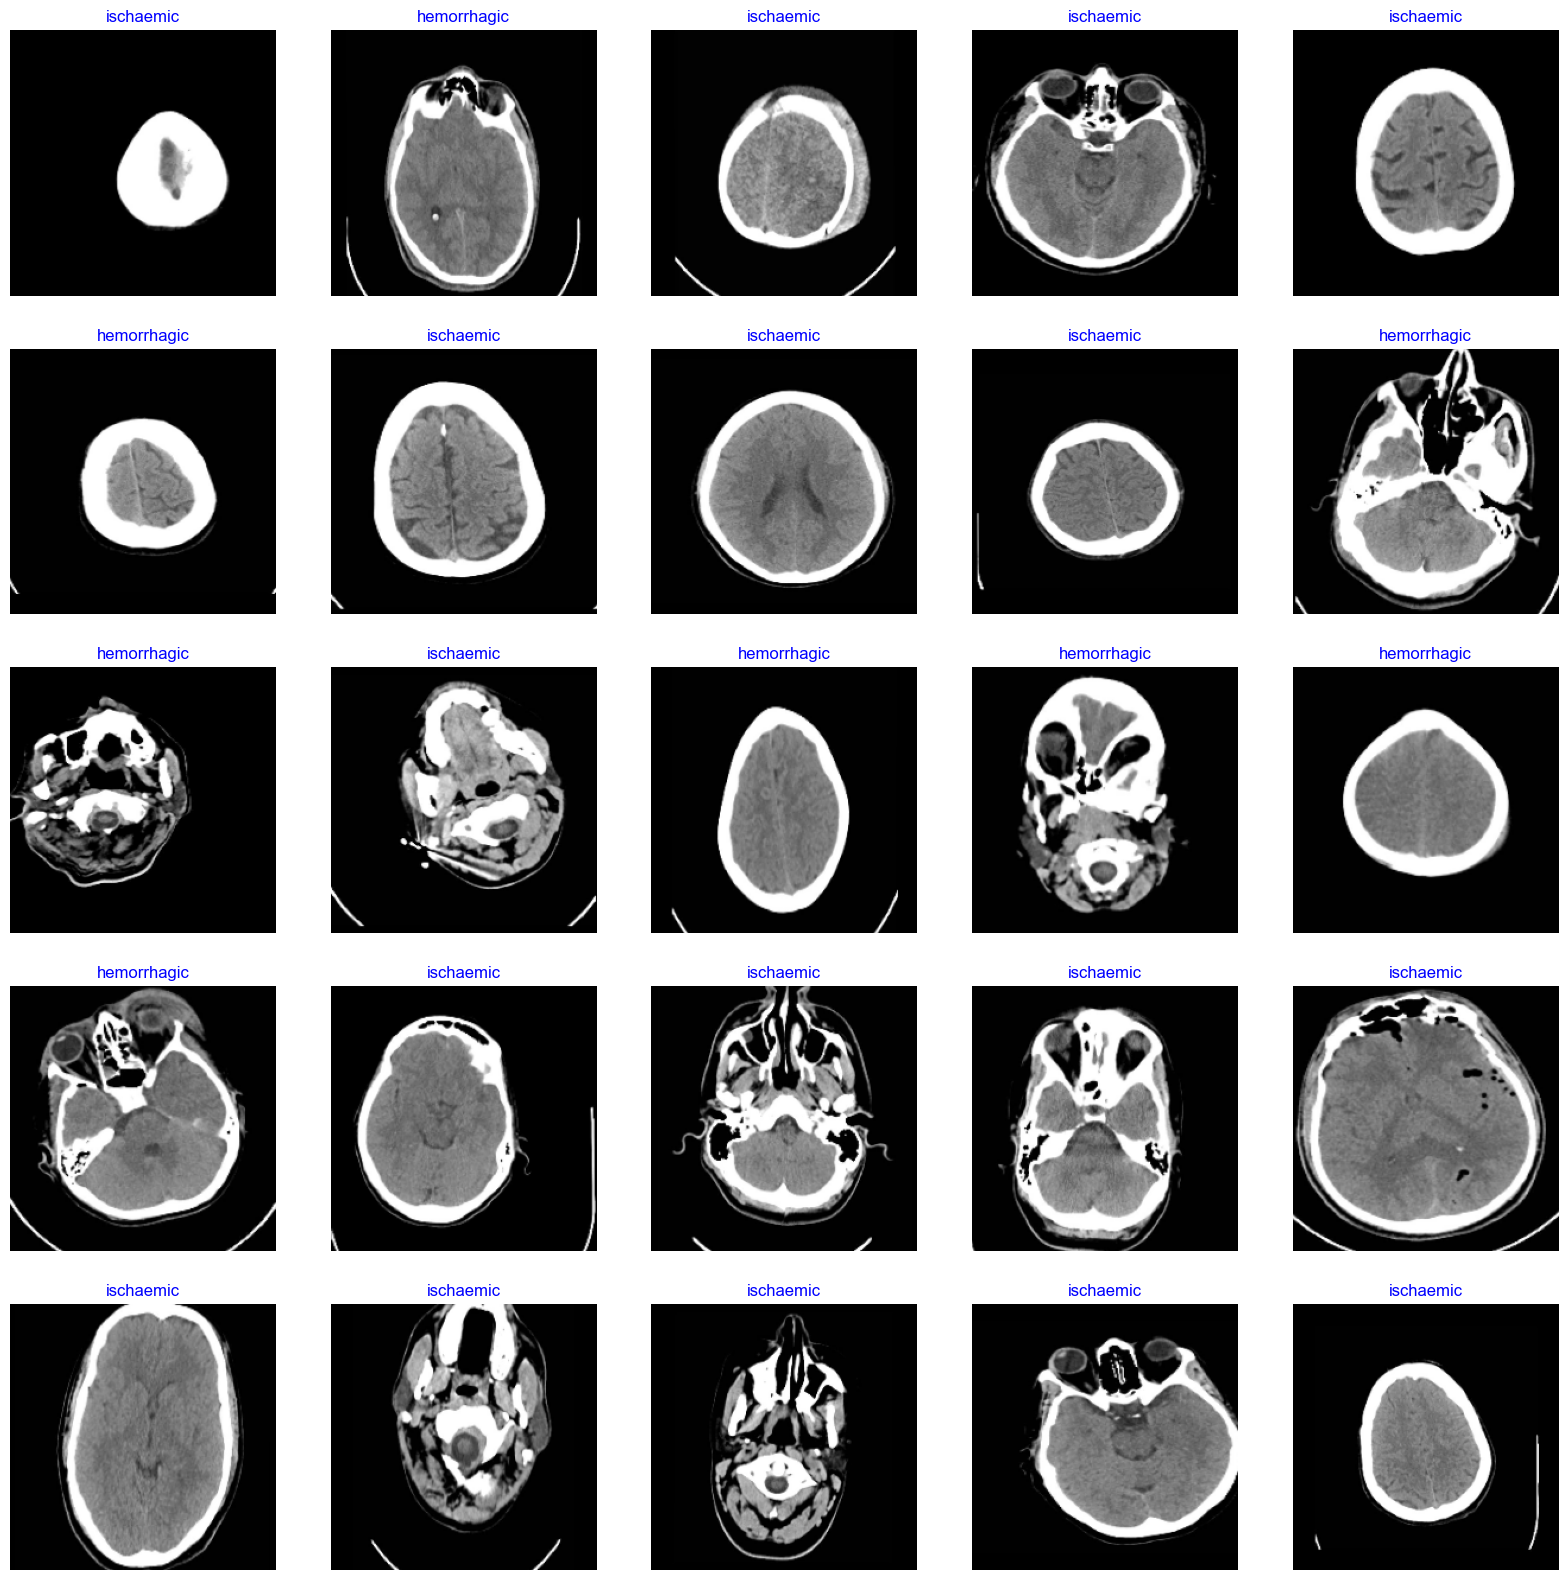

In [12]:
# Get Generators
batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)



In [13]:
# Create Model Structure using Transfer Learning (VGG16)
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1485s 26s/step - accuracy: 0.5403 - loss: 0.7485 - val_accuracy: 0.7025 - val_loss: 0.6286
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1492s 26s/step - accuracy: 0.5497 - loss: 0.7266 - val_accuracy: 0.7025 - val_loss: 0.6480
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1344s 23s/step - accuracy: 0.5557 - loss: 0.7218 - val_accuracy: 0.7002 - val_loss: 0.6475
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 365s 6s/step - accuracy: 0.5319 - loss: 0.7419 - val_accuracy: 0.7025 - val_loss: 0.6241
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 414s 7s/step - accuracy: 0.5608 - loss: 0.6986 - val_accuracy: 0.7025 - val_loss: 0.6136
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 406s 7s/step - accuracy: 0.5406 - loss: 0.7281 - val_accuracy: 0.7025 - val_loss: 0.6176
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 418s 7s/step - accuracy: 0.5861 - loss: 0.7021 - val_accuracy: 0.7025 - val_loss: 0.6214
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 389s 7s/step - accuracy: 0.5701 - loss: 0.7042 - val_accuracy: 0.70

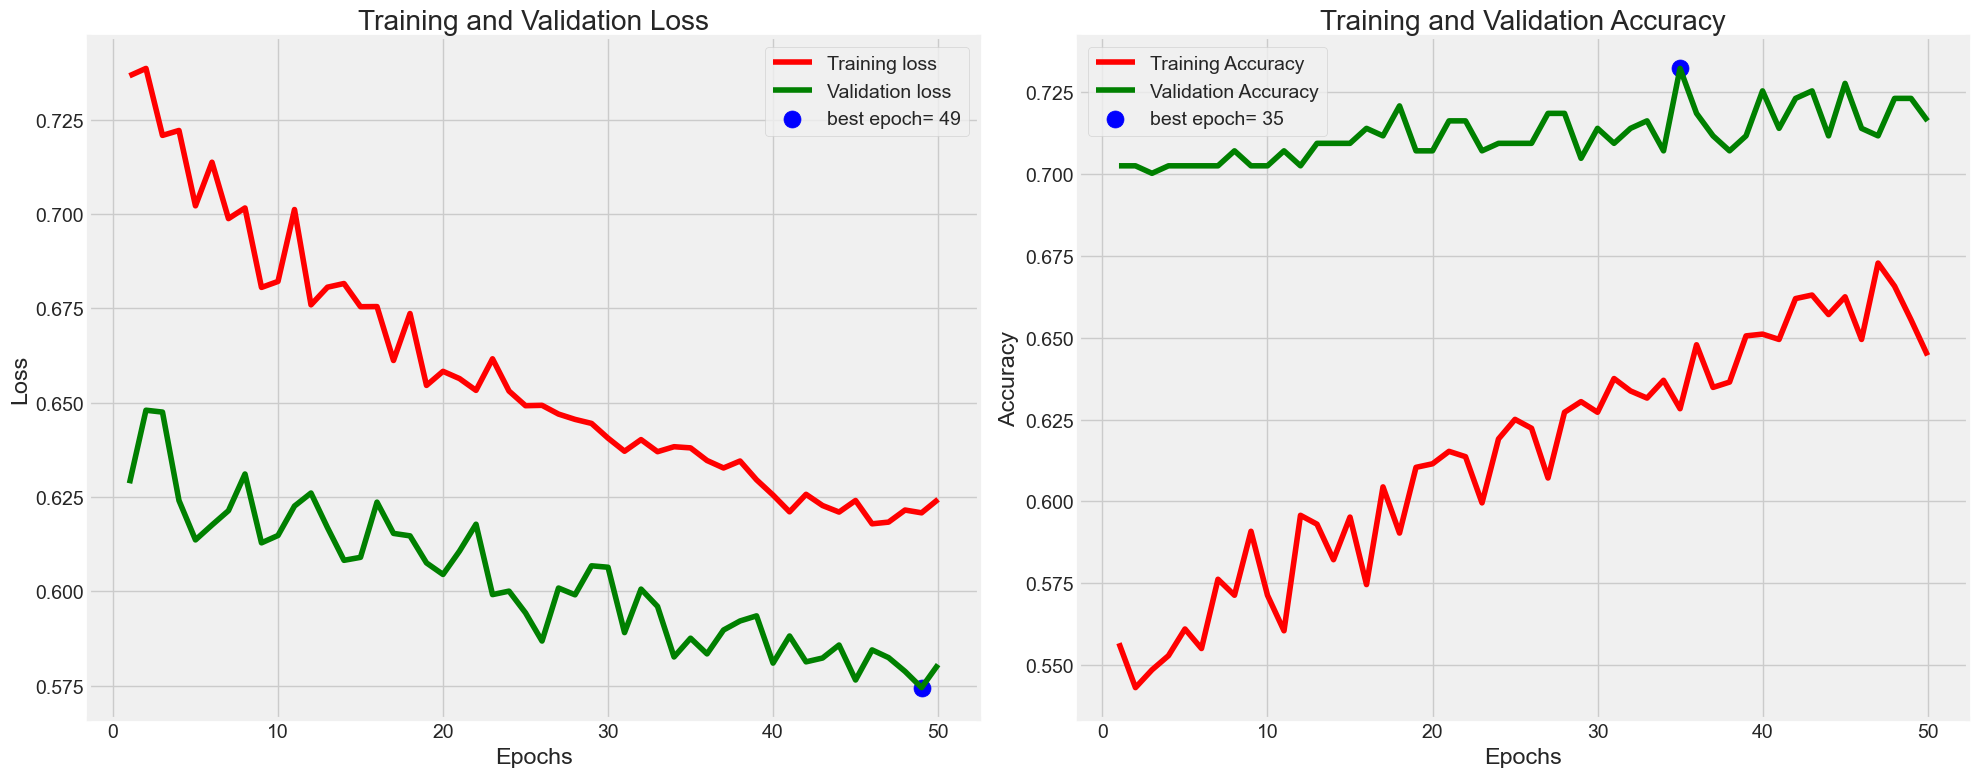

In [15]:
# Train Model
epochs = 50
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=[early_stopping])

plot_training(history)


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 465s 8s/step - accuracy: 0.6754 - loss: 0.6097 - val_accuracy: 0.7208 - val_loss: 0.5627
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1324s 23s/step - accuracy: 0.6937 - loss: 0.6004 - val_accuracy: 0.7300 - val_loss: 0.5474
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1592s 27s/step - accuracy: 0.6901 - loss: 0.5839 - val_accuracy: 0.7300 - val_loss: 0.5419
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1637s 27s/step - accuracy: 0.7160 - loss: 0.5787 - val_accuracy: 0.7162 - val_loss: 0.5482
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1604s 28s/step - accuracy: 0.7151 - loss: 0.5721 - val_accuracy: 0.7506 - val_loss: 0.5340
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1641s 28s/step - accuracy: 0.7450 - loss: 0.5514 - val_accuracy: 0.7460 - val_loss: 0.5218
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1608s 28s/step - accuracy: 0.7217 - loss: 0.5664 - val_accuracy: 0.7460 - val_loss: 0.5162
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1649s 28s/step - accuracy: 0.7226 - loss: 0.5417 - val_accura

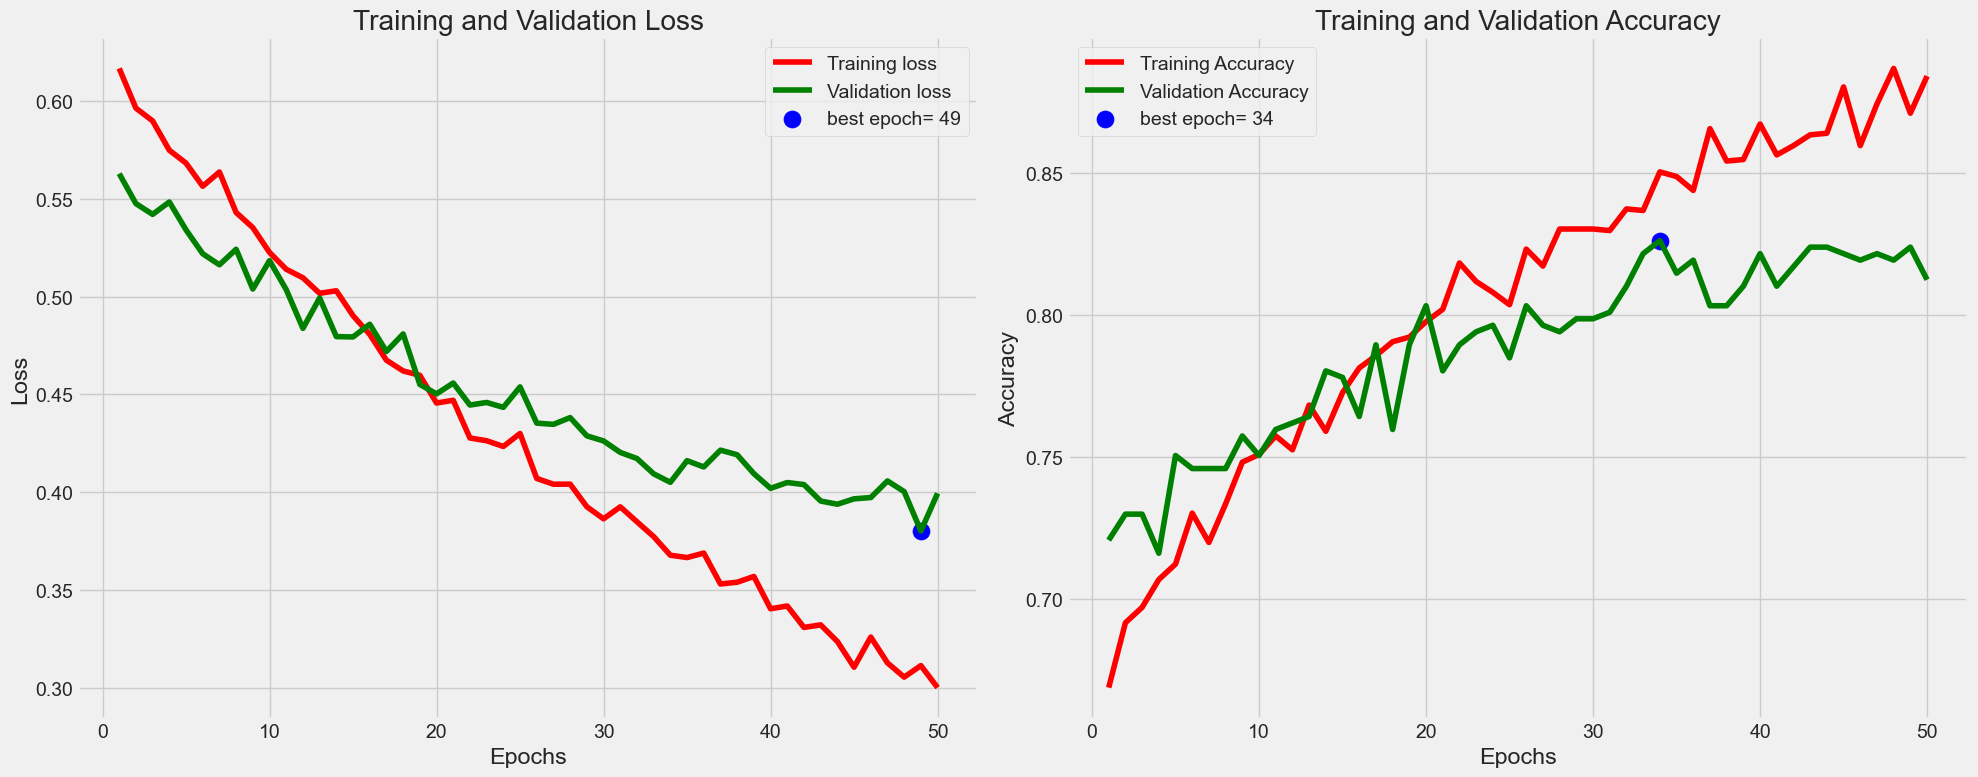

In [16]:
# Fine-tuning the model
base_model.trainable = True
# Freeze the first few layers and unfreeze the rest
for layer in base_model.layers[:15]:
    layer.trainable = False

model.compile(optimizer=Adamax(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=[early_stopping])

plot_training(history)



In [17]:
# Evaluate Model
loss, accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 150s 29s/step - accuracy: 0.8257 - loss: 0.3902
Test Accuracy: 85.11%


5/5 ━━━━━━━━━━━━━━━━━━━━ 160s 32s/step
Confusion Matrix, Without Normalization
[[ 54  24]
 [ 11 146]]
              precision    recall  f1-score   support

 hemorrhagic       0.83      0.69      0.76        78
   ischaemic       0.86      0.93      0.89       157

    accuracy                           0.85       235
   macro avg       0.84      0.81      0.82       235
weighted avg       0.85      0.85      0.85       235



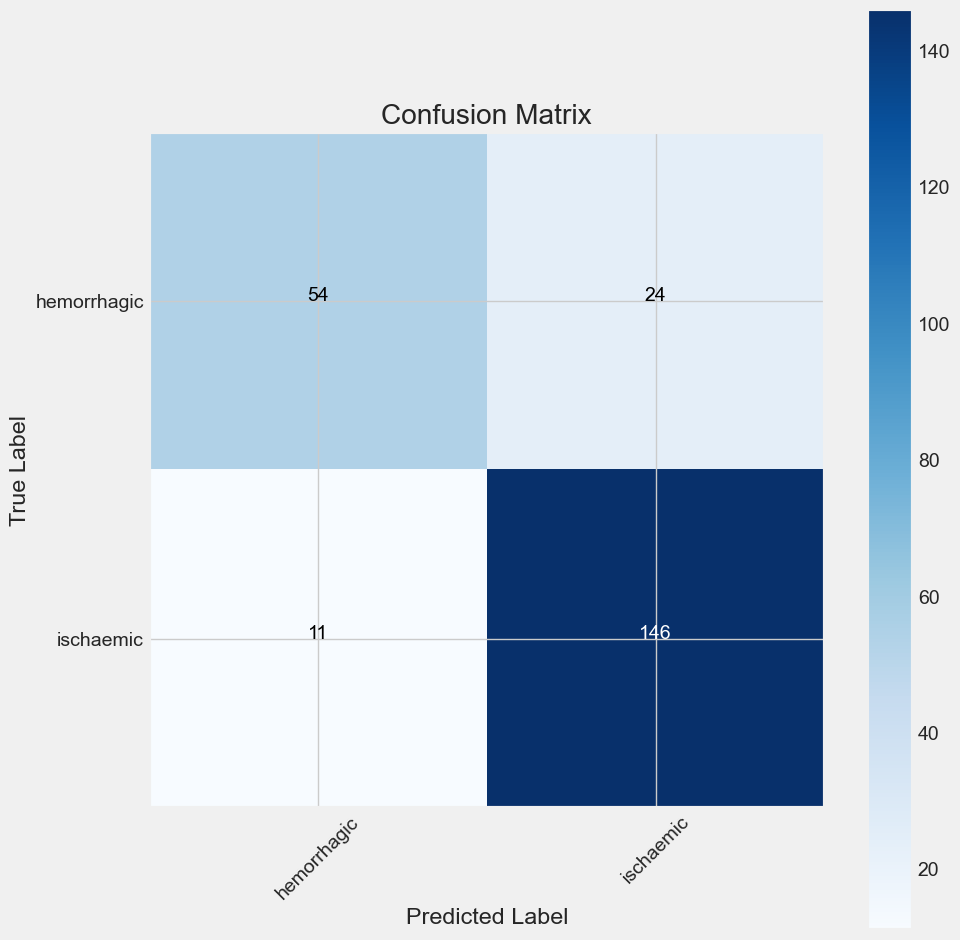

In [18]:
# Predict and Evaluate
preds = model.predict(test_gen)
pred_labels = np.argmax(preds, axis=1)
true_labels = test_gen.classes

cm = confusion_matrix(true_labels, pred_labels)
classes = list(test_gen.class_indices.keys())
plot_confusion_matrix(cm, classes)
print(classification_report(true_labels, pred_labels, target_names=classes))